<a href="https://colab.research.google.com/github/tnbsuntae/food_classification/blob/main/resnet50_model_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Access image data

Get image data from github - https://github.com/tnbsuntae/food_classification/blob/main/food_images.zip (this is the zip file that has been created from https://github.com/tnbsuntae/food_classification/blob/main/data_creation.ipynb)

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup a directory to store images
data_path = Path("data/")
zip_path = Path("food_images.zip")

# If the directory doesn't exist, download it and prepare it
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping download")
else:
  print(f"{data_path} does not exist, creating one...")
  data_path.mkdir(parents=True, exist_ok=True)

# Download the zip file
with open(zip_path, "wb") as f:
  print("Downloading food data...")
  request = requests.get("https://github.com/tnbsuntae/food_classification/raw/refs/heads/main/food_images.zip")
  f.write(request.content)

# Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  print("Unzipping food data...")
  zip_ref.extractall(data_path)

print("Download and extraction complete")

data directory already exists... skipping download
Unzipping food data...
Download and extraction complete


In [ ]:
# Check lengths of directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  import os
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(data_path)

There are 2 directories and 0 images in 'data'.
There are 12 directories and 0 images in 'data/valid'.
There are 0 directories and 25 images in 'data/valid/Egg'.
There are 0 directories and 25 images in 'data/valid/Fried Food'.
There are 0 directories and 25 images in 'data/valid/Dairy'.
There are 0 directories and 25 images in 'data/valid/Noodles'.
There are 0 directories and 25 images in 'data/valid/Soup'.
There are 0 directories and 25 images in 'data/valid/Vegetable'.
There are 0 directories and 25 images in 'data/valid/Fruit'.
There are 0 directories and 25 images in 'data/valid/Rice'.
There are 0 directories and 25 images in 'data/valid/Meat'.
There are 0 directories and 25 images in 'data/valid/Dessert'.
There are 0 directories and 25 images in 'data/valid/Bread'.
There are 0 directories and 25 images in 'data/valid/Seafood'.
There are 12 directories and 0 images in 'data/train'.
There are 0 directories and 100 images in 'data/train/Egg'.
There are 0 directories and 100 images i

In [ ]:
data_path

PosixPath('data')

### Display sample image

Image path: data/train/Bread/image_17.jpg
Image class: Bread
Image height: 536
Image width: 1024


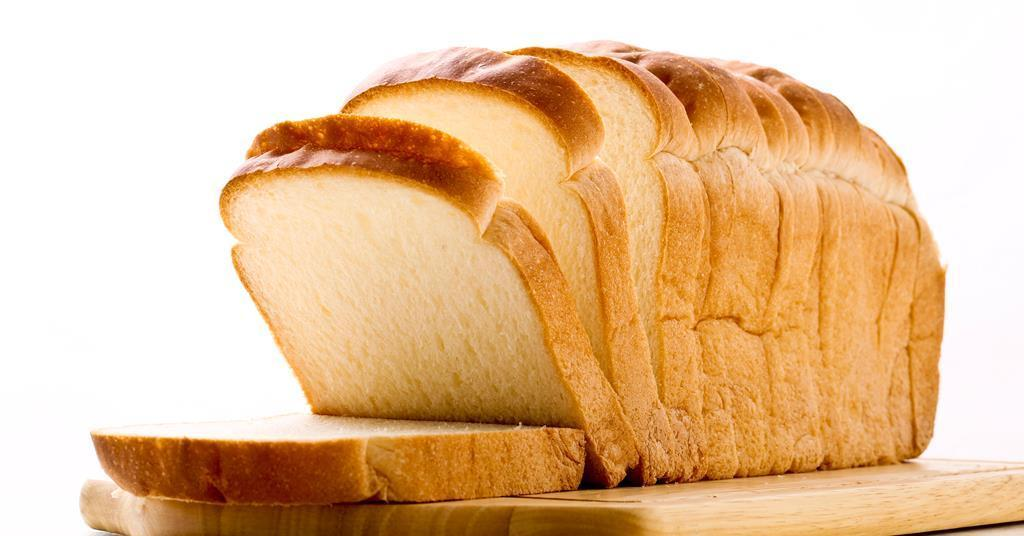

In [ ]:
import random
from PIL import Image

# Get image paths
image_path_list = list(data_path.glob("*/*/*.jpg"))

# Pick a random image
random_image_path = random.choice(image_path_list)

# Get image class
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Display image and data
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# Load `ResNet-50` model from huggingface

resource: https://huggingface.co/docs/transformers/main/en/model_doc/resnet#transformers.ResNetForImageClassification

In [ ]:
# Load model
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Display sample processed image using `ResNet-50` image processor

Text(0.5, 0.98, 'Class: Rice')

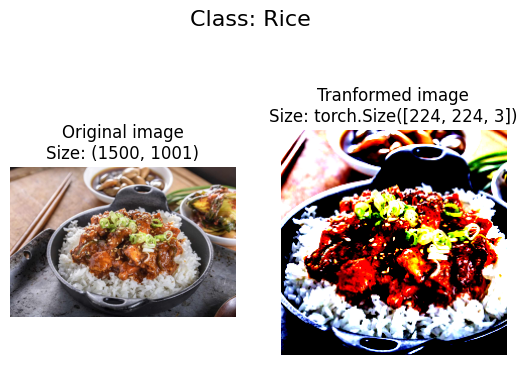

In [ ]:
import matplotlib.pyplot as plt
import torch

# Get image paths
image_path_list = list(data_path.glob("*/*/*.jpg"))

# Pick a random image
random_image_path = random.choice(image_path_list)

# Get image class
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

fig, ax = plt.subplots(nrows=1, ncols=2)
# Display original image
ax[0].imshow(img)
ax[0].set_title(f"Original image\nSize: {img.size}")
ax[0].axis(False)

# Display transformed image
preprocessed_image = processor(img, return_tensors='pt')['pixel_values'].squeeze(0).permute(1, 2, 0)
ax[1].imshow(preprocessed_image)
ax[1].set_title(f"Tranformed image\nSize: {preprocessed_image.shape}")
ax[1].axis(False)

fig.suptitle(f"Class: {random_image_path.parent.stem}", fontsize=16)

In [ ]:
# Setup train and testing paths
train_dir = data_path / "train"
valid_dir = data_path / "valid"

train_dir, valid_dir

(PosixPath('data/train'), PosixPath('data/valid'))

# Create `ImageDataset()` class for preprocessing image data

## Create `find_classes()` to extract class names and class index of the data

In [ ]:
import os

def find_classes(directory: str):
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
class_names, class_to_idx = find_classes(train_dir)
class_names, class_to_idx

(['Bread',
  'Dairy',
  'Dessert',
  'Egg',
  'Fried Food',
  'Fruit',
  'Meat',
  'Noodles',
  'Rice',
  'Seafood',
  'Soup',
  'Vegetable'],
 {'Bread': 0,
  'Dairy': 1,
  'Dessert': 2,
  'Egg': 3,
  'Fried Food': 4,
  'Fruit': 5,
  'Meat': 6,
  'Noodles': 7,
  'Rice': 8,
  'Seafood': 9,
  'Soup': 10,
  'Vegetable': 11})

## Create `ImageDataset()` class with `ResNet-50` image precessor

In [ ]:
from torch.utils.data import Dataset
import numpy as np

class ImageDataset(Dataset):
  def __init__(self, targ_dir, processor):
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))
    self.processor = processor
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index):
    """Load an image given its index"""
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    """
    Return a dictionary containing:
    - processed_image: Tensor for the image.
    - label: Class index for the image.
    """
    img = self.load_image(index)
    class_names = self.paths[index].parent.name # Path format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_names]

    # Apply preprocessing
    processed_img = self.processor(img, return_tensors='pt')['pixel_values'].squeeze(0)

    return {"image": processed_img, "label": torch.tensor(class_idx, dtype=torch.long)}

In [ ]:
train_data = ImageDataset(targ_dir=train_dir,
                                      processor=processor)
valid_data = ImageDataset(targ_dir=valid_dir,
                                      processor=processor)

### Display sample image with label and size after apply `ImageDataset` class

Sample Image Shape: torch.Size([3, 224, 224])
Sample Label: tensor(3)
Sample Class: Egg


(-0.5, 223.5, 223.5, -0.5)

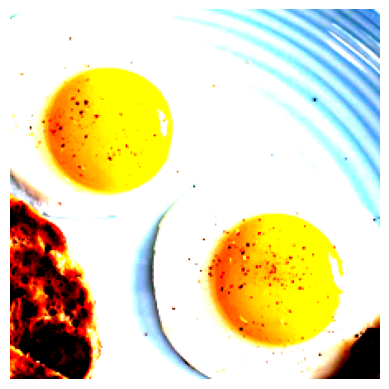

In [ ]:
sample = train_data[0]
print("Sample Image Shape:", sample["image"].shape)
print("Sample Label:", sample["label"])
print("Sample Class:", class_names[sample["label"]])
plt.imshow(sample["image"].permute(1, 2, 0))
plt.axis(False)

# Utilize `DataLoader` for batching data

In [ ]:
# Turn datasets into DataLoader
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dfb94485ae0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dfb94486b30>)

### Inspect the length of each dataloader

In [ ]:
len(train_dataloader), len(valid_dataloader)

(38, 10)

### Inspect the shape of image and label of each batch

In [ ]:
img, label = next(iter(train_dataloader))['image'], next(iter(train_dataloader))['label']

# Display size and dimensions
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


# Model Tuning

In [ ]:
!pip install torchinfo

### Display model summary using torchinfo

In [ ]:
from torchinfo import summary

# Display model summary with torchinfo
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
ResNetForImageClassification (ResNetForImageClassification)                 [1, 3, 224, 224]     [1, 1000]            --                   True
├─ResNetModel (resnet)                                                      [1, 3, 224, 224]     [1, 2048, 1, 1]      --                   True
│    └─ResNetEmbeddings (embedder)                                          [1, 3, 224, 224]     [1, 64, 56, 56]      --                   True
│    │    └─ResNetConvLayer (embedder)                                      [1, 3, 224, 224]     [1, 64, 112, 112]    9,536                True
│    │    └─MaxPool2d (pooler)                                              [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─ResNetEncoder (encoder)                                              [1, 64, 56, 56]      [1, 2048, 7, 7]      --             

### Freeze model's base layers

In [ ]:
# Freeze base layers
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

In [ ]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

resnet.embedder.embedder.convolution.weight False
resnet.embedder.embedder.normalization.weight False
resnet.embedder.embedder.normalization.bias False
resnet.encoder.stages.0.layers.0.shortcut.convolution.weight False
resnet.encoder.stages.0.layers.0.shortcut.normalization.weight False
resnet.encoder.stages.0.layers.0.shortcut.normalization.bias False
resnet.encoder.stages.0.layers.0.layer.0.convolution.weight False
resnet.encoder.stages.0.layers.0.layer.0.normalization.weight False
resnet.encoder.stages.0.layers.0.layer.0.normalization.bias False
resnet.encoder.stages.0.layers.0.layer.1.convolution.weight False
resnet.encoder.stages.0.layers.0.layer.1.normalization.weight False
resnet.encoder.stages.0.layers.0.layer.1.normalization.bias False
resnet.encoder.stages.0.layers.0.layer.2.convolution.weight False
resnet.encoder.stages.0.layers.0.layer.2.normalization.weight False
resnet.encoder.stages.0.layers.0.layer.2.normalization.bias False
resnet.encoder.stages.0.layers.1.layer.0.conv

## Modify model's classifier head to classification task

In [ ]:
# Update the classifier head
from torch import nn

model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=1024,
              out_features=len(class_names))) # how many classes do we have?

model.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=1024, out_features=12, bias=True)
)

### Display summary of the modified model

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
ResNetForImageClassification (ResNetForImageClassification)                 [1, 3, 224, 224]     [1, 12]              --                   Partial
├─ResNetModel (resnet)                                                      [1, 3, 224, 224]     [1, 2048, 1, 1]      --                   False
│    └─ResNetEmbeddings (embedder)                                          [1, 3, 224, 224]     [1, 64, 56, 56]      --                   False
│    │    └─ResNetConvLayer (embedder)                                      [1, 3, 224, 224]     [1, 64, 112, 112]    (9,536)              False
│    │    └─MaxPool2d (pooler)                                              [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─ResNetEncoder (encoder)                                              [1, 64, 56, 56]      [1, 2048, 7, 7]      --       

# Model training

### Setup device-agnostic code for utilizing `gpu` in the training process

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create `train_step()` function to create model's loop for training data

In [ ]:
# Create train step function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch in dataloader:
    # Extract data and send to target device
    X, y = batch['image'].to(device), batch['label'].to(device)

    # Forward pass
    y_pred = model(X)['logits']

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Calculate average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

## Create `valid_step()` function to create model's loop for validation data

In [ ]:
# Create valid_step function
def valid_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  valid_loss, valid_acc = 0, 0

  with torch.inference_mode():
    for batch in dataloader:
      # Extract data and send to target device
      X, y = batch['image'].to(device), batch['label'].to(device)

      # Forward pass
      y_pred = model(X)['logits']

      # Calculate loss
      loss = loss_fn(y_pred, y)
      valid_loss += loss.item()

      # Calculate accuracy
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      valid_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Calculate average loss and accuracy per batch
  valid_loss = valid_loss / len(dataloader)
  valid_acc = valid_acc / len(dataloader)

  return valid_loss, valid_acc

## Create `EarlyStopping()` class to avoid overfitting problem

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0.01, save_path="best_model.pth"):
    """
    Args:
      patience (int): Number of epochs to wait for improvement.
      delta (float): Minimum change to qualify as improvement.
      save_path (str): Path to save the best model
    """
    self.patience = patience
    self.delta = delta
    self.save_path = save_path
    self.counter = 0
    self.best_loss = float('inf')
    self.early_stop = False

  def __call__(self, val_loss, model):
    if val_loss < self.best_loss - self.delta:
      self.best_loss = val_loss
      self.counter = 0
      torch.save(model.state_dict(), self.save_path) # Save the best model
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True

## Create `train()` function to create a full training loop of the model with `train_step()`, `valid_step()`, `EarlyStopping()` included

In [ ]:
# Create train function
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          patience: int = 5,
          delta: float = 0.01,
          save_path: str = "best_model.pth",
          device=device):

  # Initialize EarlyStopping
  early_stopping = EarlyStopping(patience=patience, delta=delta, save_path=save_path)

  results = {"train_loss": [],
             "train_acc": [],
             "valid_loss": [],
             "valid_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    valid_loss, valid_acc = valid_step(model=model,
                                       dataloader=valid_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    # Print results in each epoch
    print(f"Epoch: {epoch} | Training Loss: {train_loss:.3f} | Training Accuracy: {train_acc:.3f} | Validation Loss: {valid_loss:.3f} | Validation Accuracy: {valid_acc:.3f}")

    # Store results
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['valid_loss'].append(valid_loss)
    results['valid_acc'].append(valid_acc)

    # Check and save the best epoch
    if valid_loss == min(results['valid_loss']):
      best_epoch = epoch

    # Early stopping
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
      print(f"Early stopping triggered at epoch {epoch}. Best validation loss was at epoch {best_epoch}.")
      break

  # Load the best model
  model.load_state_dict(torch.load(save_path, weights_only=True))
  print(f"Best model loaded from {save_path}")

  return results

## Train the model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 25

# Set EarlyStopping parameters
PATIENCE = 5
DELTA = 0.01
SAVE_PATH = "best_model.pth"

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {'params': model.base_model.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 1e-4}
])

# Send model to device
model = model.to(device)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      valid_dataloader=valid_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      delta=DELTA,
                      save_path=SAVE_PATH,
                      device=device)

# End the timer
end_time = timer()

# Print out time duration
total_time = end_time - start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
print(f"Total training time: {hours} hr {minutes} min")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 2.223 | Training Accuracy: 0.370 | Validation Loss: 1.843 | Validation Accuracy: 0.681
Epoch: 1 | Training Loss: 1.466 | Training Accuracy: 0.676 | Validation Loss: 1.203 | Validation Accuracy: 0.760
Epoch: 2 | Training Loss: 1.017 | Training Accuracy: 0.742 | Validation Loss: 0.956 | Validation Accuracy: 0.754
Epoch: 3 | Training Loss: 0.780 | Training Accuracy: 0.795 | Validation Loss: 0.789 | Validation Accuracy: 0.792
Epoch: 4 | Training Loss: 0.646 | Training Accuracy: 0.833 | Validation Loss: 0.741 | Validation Accuracy: 0.801
Epoch: 5 | Training Loss: 0.535 | Training Accuracy: 0.861 | Validation Loss: 0.676 | Validation Accuracy: 0.820
Epoch: 6 | Training Loss: 0.450 | Training Accuracy: 0.889 | Validation Loss: 0.663 | Validation Accuracy: 0.804
Epoch: 7 | Training Loss: 0.395 | Training Accuracy: 0.903 | Validation Loss: 0.635 | Validation Accuracy: 0.804
Epoch: 8 | Training Loss: 0.320 | Training Accuracy: 0.920 | Validation Loss: 0.601 | Validation

# Model Evaluation

## Create `plot_eval_curves()` function to visualize loss and accuracy of every epoch

In [ ]:
from typing import Dict, List

# Create a function that plots loss and acc curves
def plot_eval_curves(results: Dict[str, List[float]]):
  """Plots training curves of a  result dictionary"""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  valid_loss = results["valid_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  valid_accuracy = results["valid_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(12, 6))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, valid_loss, label="valid_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, valid_accuracy, label="valid_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

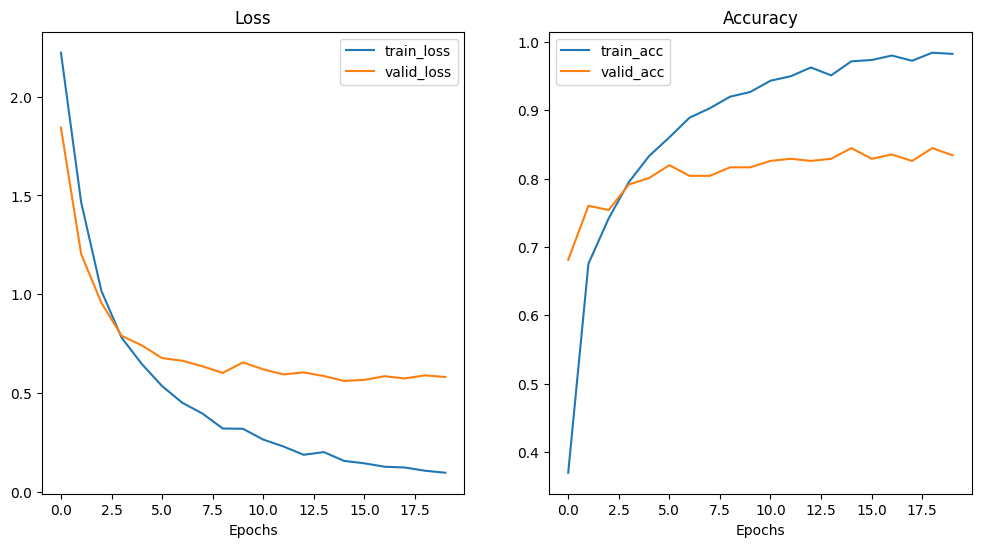

In [ ]:
plot_eval_curves(model_results)

# Make a prediction

In [ ]:
import requests

# Setup custom image path
custom_image_path = Path("sample_image.jpeg")

# Download the image if it dosen't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading form GitHub, need to use this "raw file link"
    request = requests.get("https://raw.githubusercontent.com/tnbsuntae/food_classification/refs/heads/main/sample_image.jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exist, skipping download...")

In [ ]:
custom_image_path

PosixPath('sample_image.jpeg')

# Make prediction

In [ ]:
prediction_image = Image.open(custom_image_path)
inputs = processor(prediction_image, return_tensors="pt").to(device)

In [ ]:
inputs

{'pixel_values': tensor([[[[ 1.9235,  2.1290,  2.0092,  ...,  1.5297,  1.5468,  1.4440],
          [ 2.0777,  2.0777,  1.8722,  ...,  1.4783,  1.4612,  1.3584],
          [ 2.0263,  2.0092,  1.8208,  ...,  1.4440,  1.3584,  1.3755],
          ...,
          [ 1.3927,  1.6667,  2.1462,  ..., -0.3712, -0.4739, -0.7137],
          [ 1.2728,  2.0948,  1.7352,  ..., -0.4911, -0.2684, -0.7479],
          [ 1.8722,  1.8893,  1.2899,  ..., -0.5424, -0.2856, -0.5253]],

         [[ 1.6057,  1.8683,  1.7633,  ...,  0.9930,  1.0280,  0.9930],
          [ 1.8508,  1.8859,  1.6758,  ...,  1.0105,  1.0105,  0.8880],
          [ 1.8158,  1.7108,  1.5182,  ...,  0.9755,  0.8880,  0.9055],
          ...,
          [ 0.5553,  0.9055,  1.7458,  ..., -1.1429, -1.3354, -1.4930],
          [ 0.4328,  1.7108,  1.4482,  ..., -1.2829, -1.1253, -1.4930],
          [ 1.1506,  1.5182,  0.9405,  ..., -1.3354, -1.1078, -1.2479]],

         [[ 1.4025,  1.6988,  1.5942,  ...,  0.7751,  0.8099,  0.7576],
          [ 1

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
outputs

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[-0.7502, -4.5363,  1.4067, -1.0396,  0.8703, -5.2282, -0.4620, -4.9346,
         -2.7626,  0.2152, -4.4481, -5.8955]], device='cuda:0'), hidden_states=None)

Predicted Class: Dessert
Probability: 44.05%


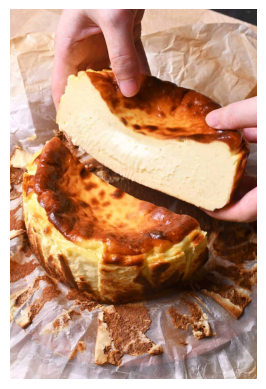

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

custom_image_uint8 = torchvision.io.read_image(custom_image_path)

prediction_logits = outputs['logits']
prediction_probs = torch.softmax(prediction_logits, dim=1)
highest_prob = prediction_probs.squeeze(0).max().item()
prediction_label = torch.argmax(prediction_probs, dim=1)

print(f"Predicted Class: {(class_names[prediction_label])}")
print(f"Probability: {highest_prob*100:.2f}%")
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Save the model

In [ ]:
from google.colab import drive
# Grant access to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create model directory path
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/personal_projects/food_image_classification'
os.makedirs(MODEL_PATH, exist_ok=True)

# Create model save
MODEL_NAME = "finetuned_resnet50.pth"
MODEL_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_NAME)

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/My Drive/Colab Notebooks/personal_projects/food_image_classification/finetuned_resnet50.pth
